## Importing packages for Forecasting

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
#warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
#from stldecompose import decompose, forecast
#from stldecompose.forecast_funcs import naive, drift, mean

# check prophet version
import prophet
# print version number
print('Prophet %s' % prophet.__version__)
from prophet import Prophet

from statsmodels.tsa.stattools import acf, pacf_ols
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error

import sys
import itertools
import warnings

import statsmodels.api as sm


Prophet 1.0


In [2]:
#from stldecompose import decompose, forecast
#from stldecompose.forecast_funcs import naive, drift, mean

In [3]:
#Establishing directory
os.chdir(r'C:\Users\itsfe\Downloads\13. Capstone Case Study - Demand Estimation')
%pwd

'C:\\Users\\itsfe\\Downloads\\13. Capstone Case Study - Demand Estimation'

In [4]:
#Importing dataset
elec_cons=pd.read_csv('Electricity Consumption.csv')

In [5]:
#Understanding the dataset
elec_cons.head()

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107


In [6]:
elec_cons.tail()

,DATE,Electricty_Consumption_in_TW
556,5/1/2019,97.5860
557,6/1/2019,110.8580
558,7/1/2019,122.1014
559,8/1/2019,121.7765
560,9/1/2019,109.7190


## Data Preprocessing

In [7]:
#Adding the missing months of 2019
new_mnths=pd.DataFrame({'DATE':['10/1/2019','11/1/2019','12/1/2019']},index=[561,562,563])
new_mnths

,DATE
561,10/1/2019
562,11/1/2019
563,12/1/2019


In [8]:
#Final table after addition of new months
cons_final=pd.concat([elec_cons,new_mnths])
cons_final

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107
...,...,...
559,8/1/2019,121.7765
560,9/1/2019,109.7190
561,10/1/2019,NaN
562,11/1/2019,NaN


In [9]:
#Info of dataset
cons_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 564 entries, 0 to 563
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATE                          564 non-null    object 
 1   Electricty_Consumption_in_TW  561 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.2+ KB


In [10]:
#Converting the date variable to datetime type
cons_final['DATE']=pd.to_datetime(cons_final.DATE,format='%m/%d/%Y')

In [11]:
cons_final.tail()

,DATE,Electricty_Consumption_in_TW
559,2019-08-01,121.7765
560,2019-09-01,109.7190
561,2019-10-01,NaN
562,2019-11-01,NaN
563,2019-12-01,NaN


In [12]:
#Extracting month and year from date
cons_final['Year']=cons_final.DATE.dt.year
cons_final['Month']=cons_final.DATE.dt.month

## EDA

In [13]:
# creating series True or False for NaN data and present data respectively. 
null_data = pd.isnull(cons_final['Electricty_Consumption_in_TW']) 
    
# print only the data where Electricity Consumption = NaN 
cons_final[null_data]

,DATE,Electricty_Consumption_in_TW,Year,Month
561,2019-10-01,NaN,2019,10
562,2019-11-01,NaN,2019,11
563,2019-12-01,NaN,2019,12


In [14]:
cons=elec_cons.Electricty_Consumption_in_TW

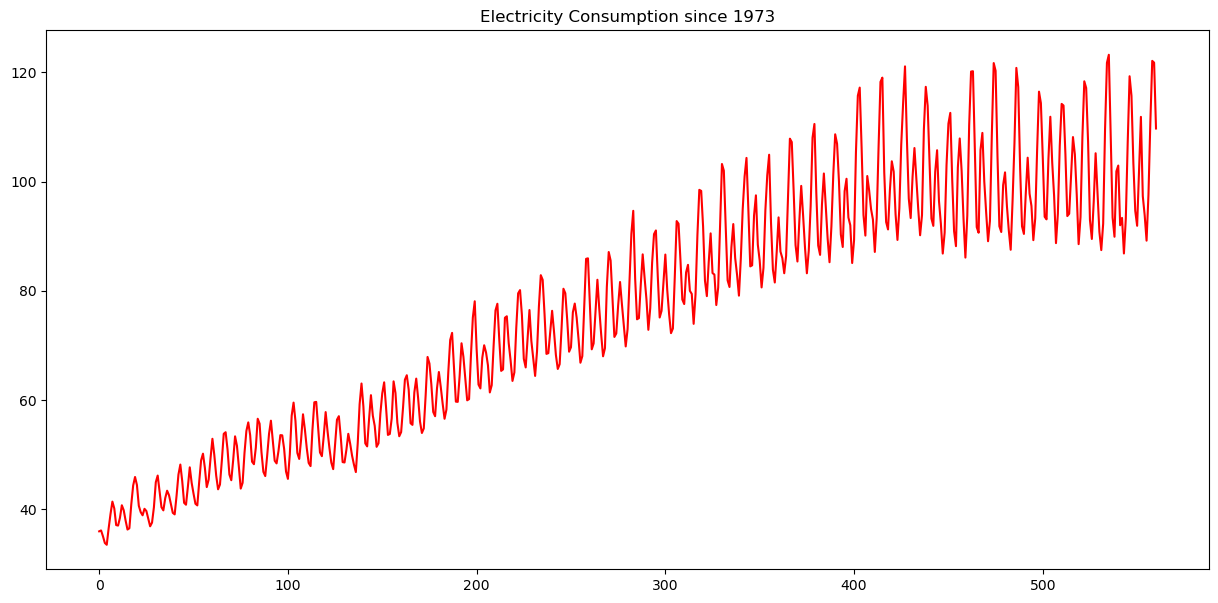

In [15]:
# set the size of our plot
plt.rcParams['figure.figsize']=(15,7)
# plots our series
plt.plot(cons, color='red')
# adds title to our time series plot
plt.title('Electricity Consumption since 1973') 
# print the plot
plt.show()

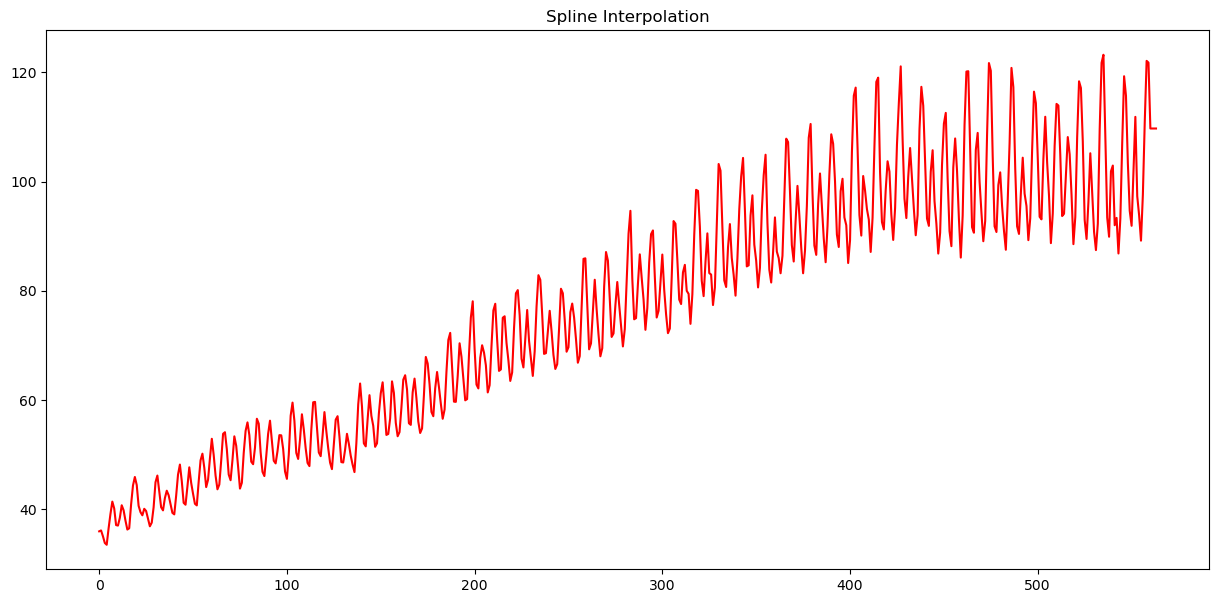

In [16]:
#Missing value imputation
# setting the plot size
plt.rcParams['figure.figsize']=(15,7)
# on our data, impute the missing values using the interpolation techniques and specifically, the lineare method
cons_final['Consumption_Spline']= cons_final['Electricty_Consumption_in_TW'].interpolate(option='spline')
# plot the complete dataset
plt.plot(cons_final['Consumption_Spline'], color='red')
# add the tittle of our plot as Linear interpolation
plt.title('Spline Interpolation')
# print the plot
plt.show()

In [17]:
#Setting date column as index column
cons_final.set_index('DATE',inplace=True)

In [18]:
cons_final.head()
cons_final.tail()

,Electricty_Consumption_in_TW,Year,Month,Consumption_Spline
DATE,,,,
2019-08-01,121.7765,2019,8,121.7765
2019-09-01,109.7190,2019,9,109.7190
2019-10-01,NaN,2019,10,109.7190
2019-11-01,NaN,2019,11,109.7190
2019-12-01,NaN,2019,12,109.7190


In [19]:
#Electricity consumption indexed on year
cons_yearly=pd.pivot_table(data=cons_final,index='Year',columns='Month',values='Consumption_Spline')
cons_yearly.head()

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
1973,35.9728,36.1334,35.0625,33.8416,33.5107,36.4823,39.1412,41.4137,40.1639,37.1133,37.0248,38.4341
1974,40.7455,39.8340,37.9408,36.3004,36.5293,40.8899,44.3563,45.9240,44.4555,40.6417,39.4901,38.9068
1975,40.0956,39.6944,38.3040,36.8939,37.5668,40.3832,44.9671,46.1853,43.3001,40.3836,39.8092,42.0597
1976,43.4099,42.5826,40.9244,39.3533,39.0766,42.4851,46.3693,48.1945,45.1688,41.1880,40.8431,44.1468
1977,47.6892,44.8505,42.8557,41.0177,40.7201,45.0610,48.9685,50.1898,47.5982,44.0684,45.4267,49.3447


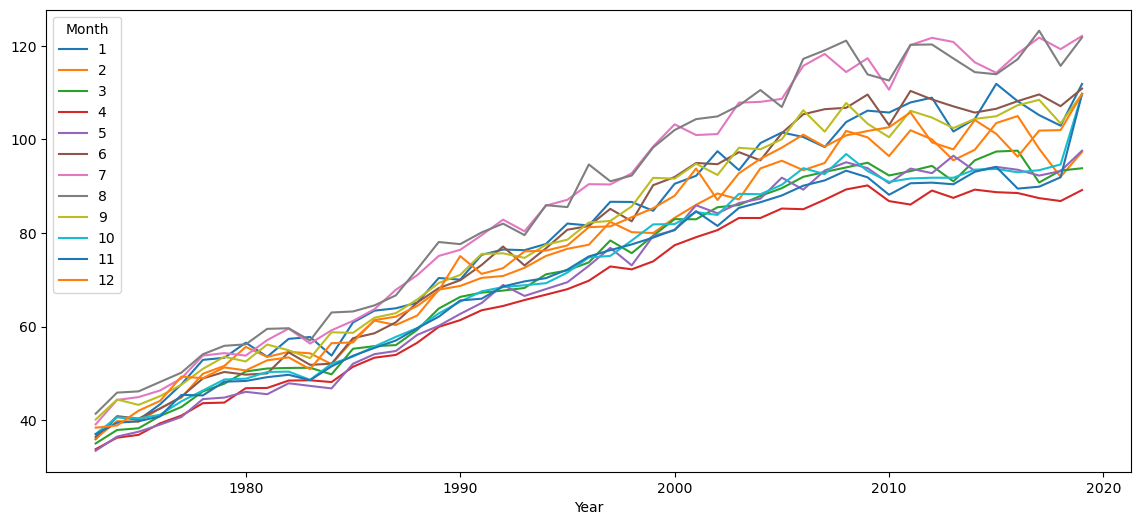

In [20]:
#Visualizing the trend over years
cons_yearly.plot(kind='line',figsize=[14,6])
plt.show()

In [21]:
#Electricity consumption indexed on month
cons_monthly=pd.pivot_table(data=cons_final,index='Month',columns='Year',values='Consumption_Spline')
cons_monthly.head()


Year,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Month,,,,,,,,,,,,,,,,,,,,,
1,35.9728,40.7455,40.0956,43.4099,47.6892,52.9153,53.3617,56.5838,53.5867,57.4002,...,105.7413,107.8967,108.9151,101.6890,104.3752,111.8708,108.1515,105.1879,102.9398,111.8520
2,36.1334,39.8340,39.6944,42.5826,44.8505,49.9488,51.6279,55.6802,53.5461,54.6248,...,96.4428,101.9572,100.0117,95.5366,97.7907,103.4990,104.9900,98.0069,92.0095,97.3261
3,35.0625,37.9408,38.3040,40.9244,42.8557,46.1749,47.8264,50.4428,51.0708,51.1896,...,92.2986,93.2285,94.3484,91.0434,95.5280,97.4134,97.5969,90.8029,93.3526,93.8406
4,33.8416,36.3004,36.8939,39.3533,41.0177,43.6652,43.7935,46.8693,46.9172,48.4958,...,86.8242,86.0874,89.0821,87.5189,89.2783,88.7323,88.5477,87.4594,86.8386,89.1873
5,33.5107,36.5293,37.5668,39.0766,40.7201,44.5402,44.8591,46.0886,45.5795,47.9140,...,90.6389,93.7706,92.7937,96.5166,93.2729,94.1360,93.5168,92.2811,93.2361,97.5860


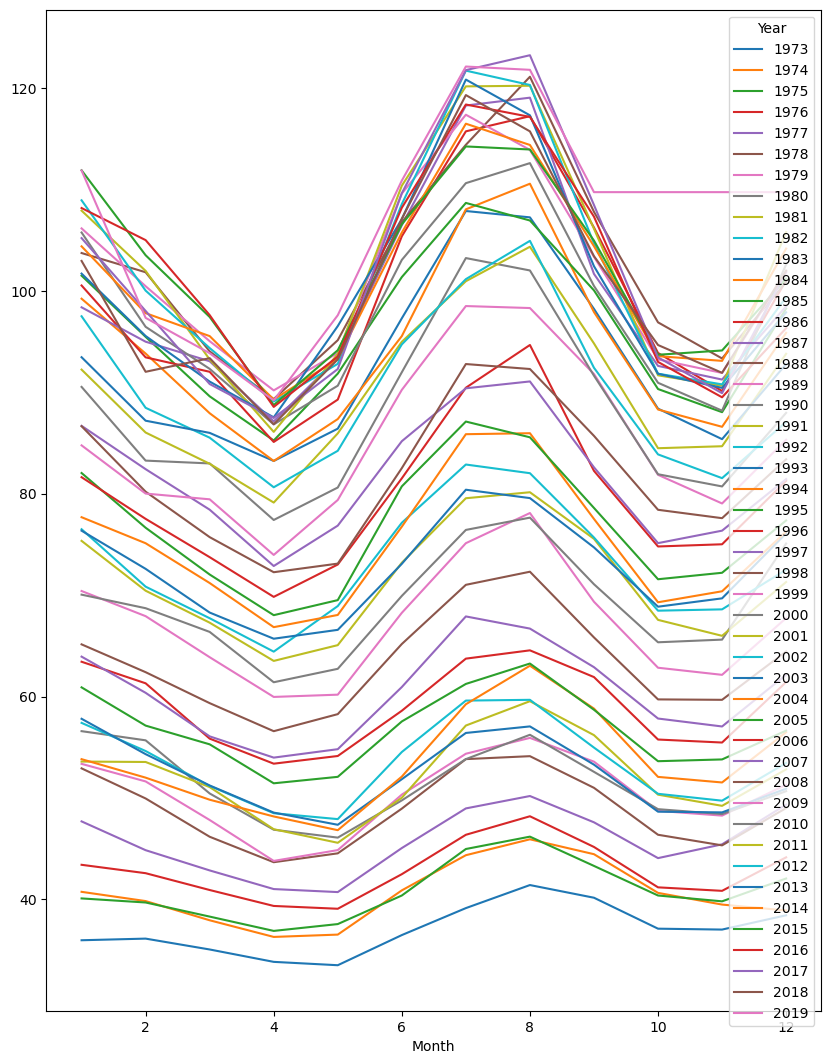

In [22]:
#Visualisation of electricity consumption over months
cons_monthly.plot(kind='line',figsize=[10,13])
plt.show()

In [23]:
cons_spline=cons_final.Consumption_Spline
cons_spline

DATE
1973-01-01     35.9728
1973-02-01     36.1334
1973-03-01     35.0625
1973-04-01     33.8416
1973-05-01     33.5107
                ...   
2019-08-01    121.7765
2019-09-01    109.7190
2019-10-01    109.7190
2019-11-01    109.7190
2019-12-01    109.7190
Name: Consumption_Spline, Length: 564, dtype: float64

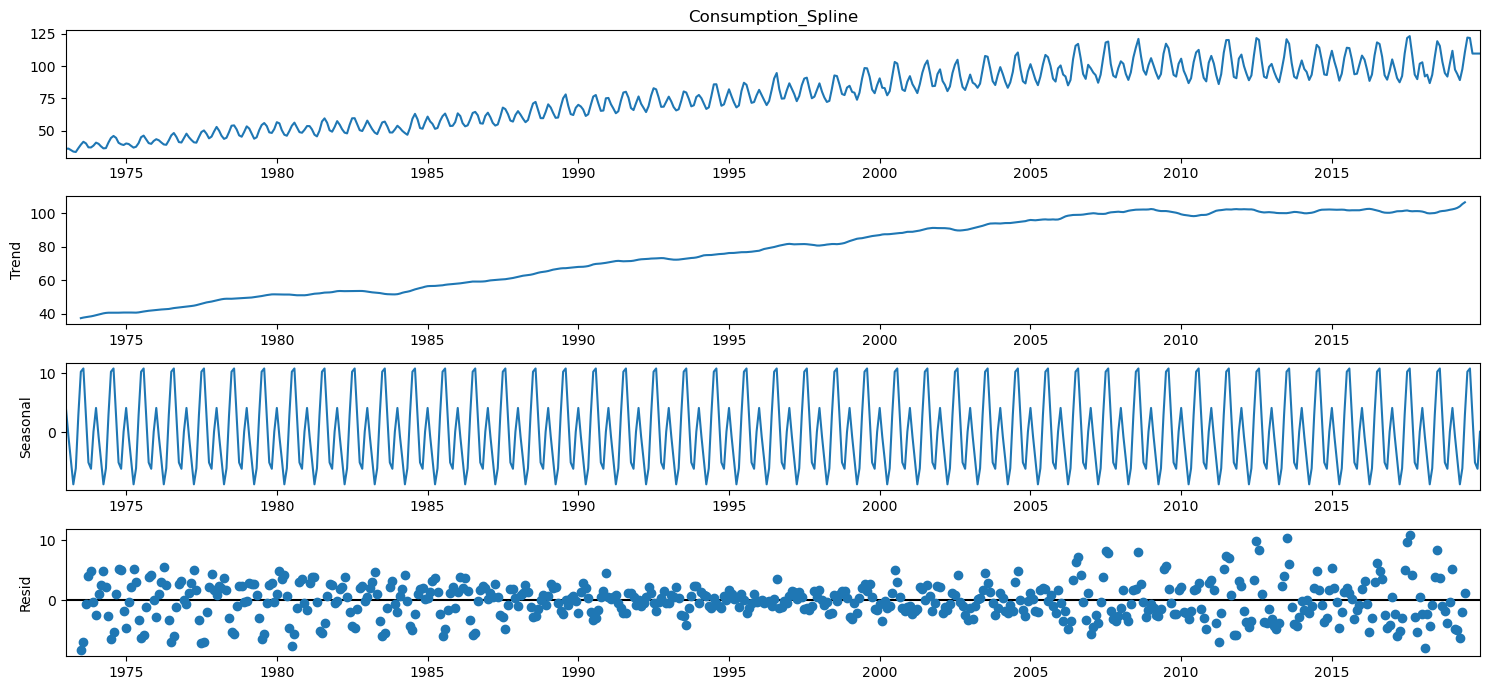

In [24]:
#Understanding the Seasonal,Trend and Residual components of data
decom = seasonal_decompose(cons_spline, model='additive')
decom.plot()
plt.show()

In [25]:
pd.concat([decom.observed, decom.trend, decom.seasonal, decom.resid], axis=1).head()

,Consumption_Spline,trend,seasonal,resid
DATE,,,,
1973-01-01,35.9728,NaN,4.148296,NaN
1973-02-01,36.1334,NaN,-0.693381,NaN
1973-03-01,35.0625,NaN,-4.477137,NaN
1973-04-01,33.8416,NaN,-8.793212,NaN
1973-05-01,33.5107,NaN,-6.073853,NaN


## Forecasting Using ETS model


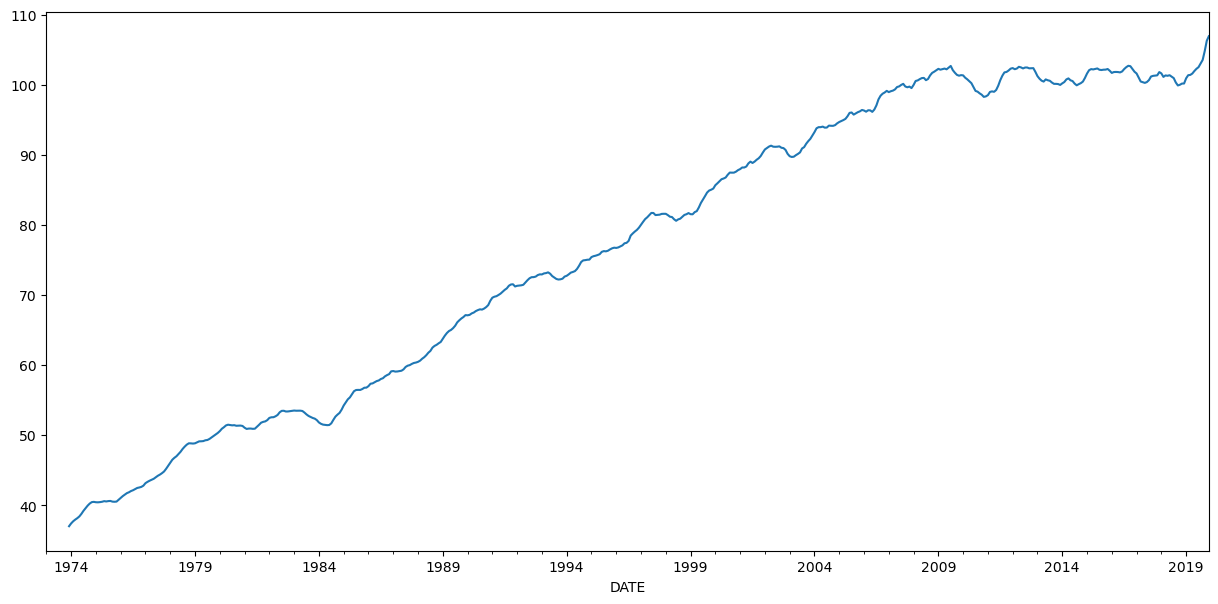

In [26]:
# Moving average plot to find the periods
cons_spline.rolling(window=12).mean().plot()
plt.show()

In [27]:
# Establishing grid for alpha,beta and gamma
alpha = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
beta = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
gamma =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

In [28]:
#Data for forward testing
cons_spline.tail(10)

DATE
2019-03-01     93.8406
2019-04-01     89.1873
2019-05-01     97.5860
2019-06-01    110.8580
2019-07-01    122.1014
2019-08-01    121.7765
2019-09-01    109.7190
2019-10-01    109.7190
2019-11-01    109.7190
2019-12-01    109.7190
Name: Consumption_Spline, dtype: float64

In [29]:
def auto_hwm(timeseries, val_split_date, alpha=[None], beta=[None], gamma=[None], 
              trend=None, seasonal=None, periods=None, verbose=False):

    best_params = []
    actual = timeseries[val_split_date:]

    print('Evaluating Exponential Smoothing model for', len(alpha) * len(beta) * len(gamma), 'fits\n')

    for a in alpha:
        for b in beta:
            for g in gamma:

                    if(verbose == True):
                        print('Checking for', {'alpha': a, 'beta': b, 'gamma': g})

                    model = ExponentialSmoothing(timeseries, trend=trend, seasonal=seasonal, seasonal_periods=periods)
                    model.fit(smoothing_level=a, smoothing_slope=b, smoothing_seasonal=g)
                    f_cast = model.predict(model.params, start=actual.index[0])
                    score = np.where(np.float64(mean_absolute_error(actual, f_cast)/actual).mean()>0,np.float64(mean_absolute_error(actual, f_cast)/actual).mean(),0)

                    best_params.append({'alpha': a, 'beta': b, 'gamma': g, 'mae': score})

    return min(best_params, key=lambda x: x['mae'])

In [30]:
#Find the best values of alpha,beta and gamma
auto_hwm(cons_spline, val_split_date ='2019-03-01' , alpha=alpha, beta=beta, gamma=gamma, 
              trend='add', seasonal='add', periods=12, verbose=True)

Evaluating Exponential Smoothing model for 729 fits

Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.7}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.9}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.1}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.7}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.9}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.2}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.3}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.7}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.4}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.7}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.9}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.7}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.9}
Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.7}
Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.7, 'gamma': 0.9}
Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.7}
Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.8, 'gamma': 0.9}
Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.1}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.8}
Checking for {'alpha': 0.1, 'beta': 0.9, 'gamma': 0.9}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.2}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.7}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.7}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.8}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.8}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.8}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.9}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.7}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.7}
Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.2, 'beta': 0.7, 'gamma': 0.9}
Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.7}
Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.8}
Checking for {'alpha': 0.2, 'beta': 0.8, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.8}
Checking for {'alpha': 0.2, 'beta': 0.9, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.7}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.9}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.8}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.9}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.8}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.8}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.7}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.9}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.3}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.8}
Checking for {'alpha': 0.3, 'beta': 0.7, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.7}
Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.3, 'beta': 0.8, 'gamma': 0.9}
Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.4}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.7}
Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.3, 'beta': 0.9, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.4}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.8}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.4}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.8}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.2}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.8}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.3}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.4}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.4, 'beta': 0.7, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.4, 'beta': 0.8, 'gamma': 0.9}
Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.4}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.7}
Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.4, 'beta': 0.9, 'gamma': 0.9}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.4}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.7}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.9}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.3}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.7}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.8}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.9}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.1}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.8}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.4}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.7}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.8}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:

Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\ts

Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.7}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.8}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.9}
Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.3}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.7}
Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.5, 'beta': 0.7, 'gamma': 0.9}
Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.7}
Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.8}
Checking for {'alpha': 0.5, 'beta': 0.8, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.7}
Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.5, 'beta': 0.9, 'gamma': 0.9}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.7}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.9}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.1}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.7}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.8}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.8}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.4}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.7}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.7}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.8}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.9}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.3}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.9}
Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.7}
Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.8}
Checking for {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.9}
Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.8}
Checking for {'alpha': 0.6, 'beta': 0.8, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\ts

Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.7}
Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.6, 'beta': 0.9, 'gamma': 0.9}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.7}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.9}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.2}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.7}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.8}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.9}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.1}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.2}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.7}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.8}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.9}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.2}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:

Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\ts

Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.7}
Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.8}
Checking for {'alpha': 0.7, 'beta': 0.7, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.7}
Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Checking for {'alpha': 0.7, 'beta': 0.8, 'gamma': 0.9}
Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.4}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:

Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.8}
Checking for {'alpha': 0.7, 'beta': 0.9, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.7}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.9}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.8}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.9}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.8}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.4}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.7}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:

Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.7}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.8}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:

Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.7}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\ts

Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.7}
Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.8, 'beta': 0.7, 'gamma': 0.9}
Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.8}
Checking for {'alpha': 0.8, 'beta': 0.8, 'gamma': 0.9}
Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.7}
Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.8, 'beta': 0.9, 'gamma': 0.9}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.7}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.8}
Checking for {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.9}
Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.2}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.7}
Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.8}
Checking for {'alpha': 0.9, 'beta': 0.2, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.7}
Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.8}
Checking for {'alpha': 0.9, 'beta': 0.3, 'gamma': 0.9}
Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.2}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.7}
Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.9, 'beta': 0.4, 'gamma': 0.9}
Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.7}
Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-

Checking for {'alpha': 0.9, 'beta': 0.5, 'gamma': 0.9}
Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.7}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:

Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.8}
Checking for {'alpha': 0.9, 'beta': 0.6, 'gamma': 0.9}
Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.2}
Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.3}
Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.4}
Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.6}
Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.7}
Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.9, 'beta': 0.7, 'gamma': 0.9}
Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.2}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.3}
Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.4}
Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.5}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.6}
Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.7}
Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.9, 'beta': 0.8, 'gamma': 0.9}
Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.1}
Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.2}
Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.3}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.4}
Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.5}
Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.6}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.7}
Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.8}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checking for {'alpha': 0.9, 'beta': 0.9, 'gamma': 0.9}


C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


{'alpha': 0.1, 'beta': 0.6, 'gamma': 0.2, 'mae': array(0.02558555)}

In [31]:
#Splitting data for backward and forward testing
train=cons_spline[:'2019-03-01']
test=cons_spline['2019-04-01':]

In [32]:
#Building model on train
ets_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.6, smoothing_seasonal=0.2)
ets_model

C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [33]:
#Backward forecasting
back_pred=ets_model.fittedvalues['2017-04-01':]
back_pred

DATE
2017-04-01     85.669082
2017-05-01     90.307627
2017-06-01    103.033237
2017-07-01    113.388173
2017-08-01    113.588501
2017-09-01    103.910877
2017-10-01     93.633546
2017-11-01     93.210540
2017-12-01    102.764091
2018-01-01    109.742855
2018-02-01    103.123267
2018-03-01     95.964840
2018-04-01     89.390323
2018-05-01     93.847428
2018-06-01    107.296341
2018-07-01    116.985199
2018-08-01    116.124662
2018-09-01    103.114160
2018-10-01     89.896410
2018-11-01     88.080718
2018-12-01     97.992857
2019-01-01    103.726844
2019-02-01     98.085769
2019-03-01     94.632139
dtype: float64

In [34]:
#Actual train data since 2017-04-01
back_actual=train['2017-04-01':]
back_actual

DATE
2017-04-01     87.4594
2017-05-01     92.2811
2017-06-01    109.6104
2017-07-01    121.7478
2017-08-01    123.2163
2017-09-01    108.4514
2017-10-01     93.4264
2017-11-01     89.9026
2017-12-01    101.8836
2018-01-01    102.9398
2018-02-01     92.0095
2018-03-01     93.3526
2018-04-01     86.8386
2018-05-01     93.2361
2018-06-01    107.1009
2018-07-01    119.2874
2018-08-01    115.7108
2018-09-01    103.4070
2018-10-01     94.6492
2018-11-01     91.9079
2018-12-01    101.9883
2019-01-01    111.8520
2019-02-01     97.3261
2019-03-01     93.8406
Name: Consumption_Spline, dtype: float64

In [35]:
#Forecasting for test data
f_cast=ets_model.forecast(10)
f_cast

2019-04-01     89.330118
2019-05-01     95.661901
2019-06-01    110.523230
2019-07-01    122.010992
2019-08-01    121.518724
2019-09-01    109.857480
2019-10-01     98.651398
2019-11-01     97.039099
2019-12-01    107.236336
2020-01-01    113.791158
Freq: MS, dtype: float64

In [36]:
#Train Error
print('train error',np.mean(np.abs(back_actual-back_pred)/back_actual))

train error 0.034851276455642476


In [37]:
#Test Error
print('test error',np.mean(np.abs(test-f_cast)/test))

test error 0.029724914045484288


In [38]:
#Building ETS model on the whole given data
ets_model = ExponentialSmoothing(cons_spline, trend='add', seasonal='add', seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5, smoothing_seasonal=0.2)
ets_model 

C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [39]:
#Model Summary
print(ets_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:       Consumption_Spline   No. Observations:                  564
Model:             ExponentialSmoothing   SSE                           4005.471
Optimized:                         True   AIC                           1137.644
Trend:                         Additive   BIC                           1207.005
Seasonal:                      Additive   AICC                          1138.899
Seasonal Periods:                    12   Date:                 Mon, 28 Nov 2022
Box-Cox:                          False   Time:                         14:38:05
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha                False
smoothing_trend          

In [40]:
#Forecasting the Electricity Demand for next two years 2020 and 2021
fcast_ets=ets_model.forecast(24)
fcast_ets

2020-01-01    118.635258
2020-02-01    111.430264
2020-03-01    109.097206
2020-04-01    105.090891
2020-05-01    112.915235
2020-06-01    128.468961
2020-07-01    140.957805
2020-08-01    141.570769
2020-09-01    130.907632
2020-10-01    123.040077
2020-11-01    122.517187
2020-12-01    131.608861
2021-01-01    139.275761
2021-02-01    132.070767
2021-03-01    129.737708
2021-04-01    125.731394
2021-05-01    133.555738
2021-06-01    149.109464
2021-07-01    161.598307
2021-08-01    162.211272
2021-09-01    151.548134
2021-10-01    143.680579
2021-11-01    143.157690
2021-12-01    152.249364
Freq: MS, dtype: float64

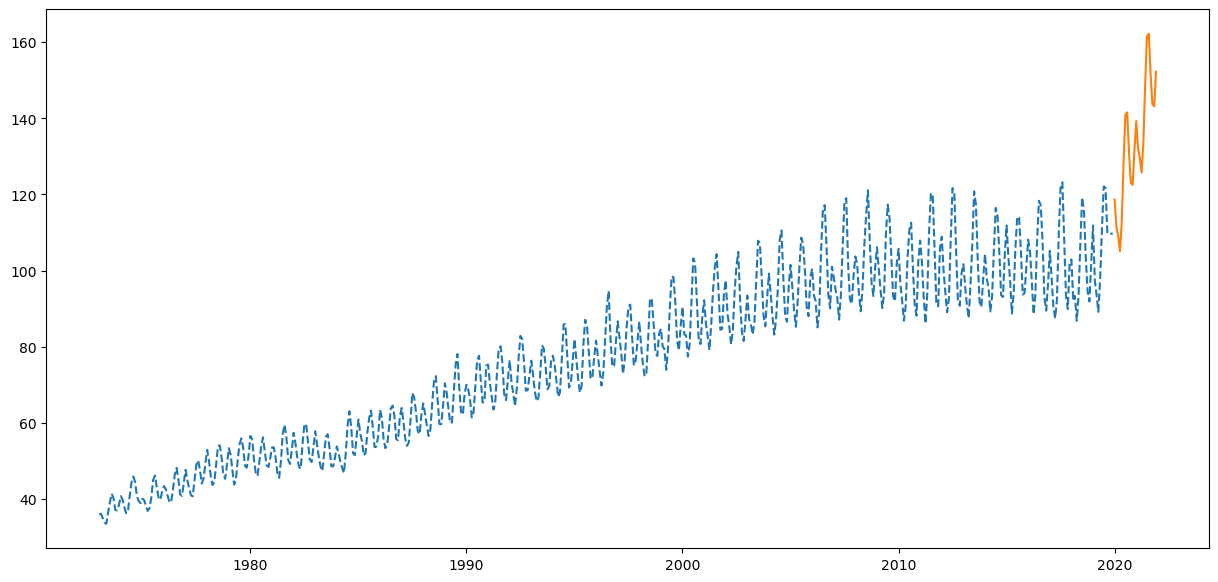

In [41]:
#Plotting of observed and forecasted values using Holtwinter Method
plt.plot(cons_spline,'--',label='Observed')
plt.plot(fcast_ets,'-',label='Forecasted')

## Forecasting Using SARIMA model

In [42]:
#Autocorrelation of target values
acf(cons_spline)

array([1.        , 0.95695262, 0.88093126, 0.83408602, 0.8461501 ,
       0.88950995, 0.90864433, 0.8777902 , 0.8244384 , 0.80496759,
       0.84322016, 0.90754333, 0.93650283, 0.89719354, 0.82628303,
       0.7829755 , 0.79685354, 0.84032704, 0.85890842, 0.8292542 ,
       0.77766757, 0.75861978, 0.79604023, 0.85948716, 0.88749084,
       0.84893781, 0.78039465, 0.738632  ])

In [43]:
#Partial Autocorrelation of target values
pacf_ols(cons_spline)

array([ 1.        ,  0.96050397, -0.45763183,  0.67958903,  0.45245329,
        0.15777771, -0.18916177, -0.00656006,  0.17405677,  0.50029824,
        0.47499533,  0.48149421,  0.3558007 , -0.42744557, -0.04649009,
       -0.12804732,  0.10383071, -0.01939568, -0.02054217,  0.02718361,
       -0.09155547, -0.02582067,  0.08795937,  0.22690253,  0.14654255,
       -0.07626552,  0.02211713, -0.05981741])

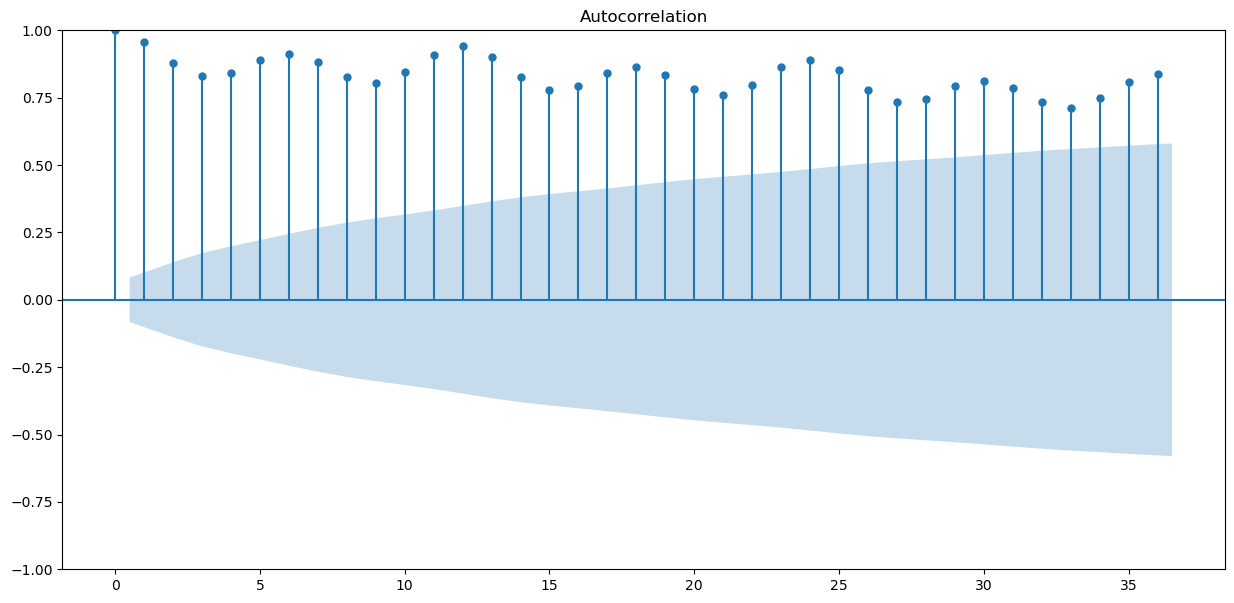

In [44]:
#Correlogram of acf
smt.graphics.plot_acf(cons, lags=36)
plt.show()

Series is seasonal - SARIMA Model
value of q = 2, Q=1

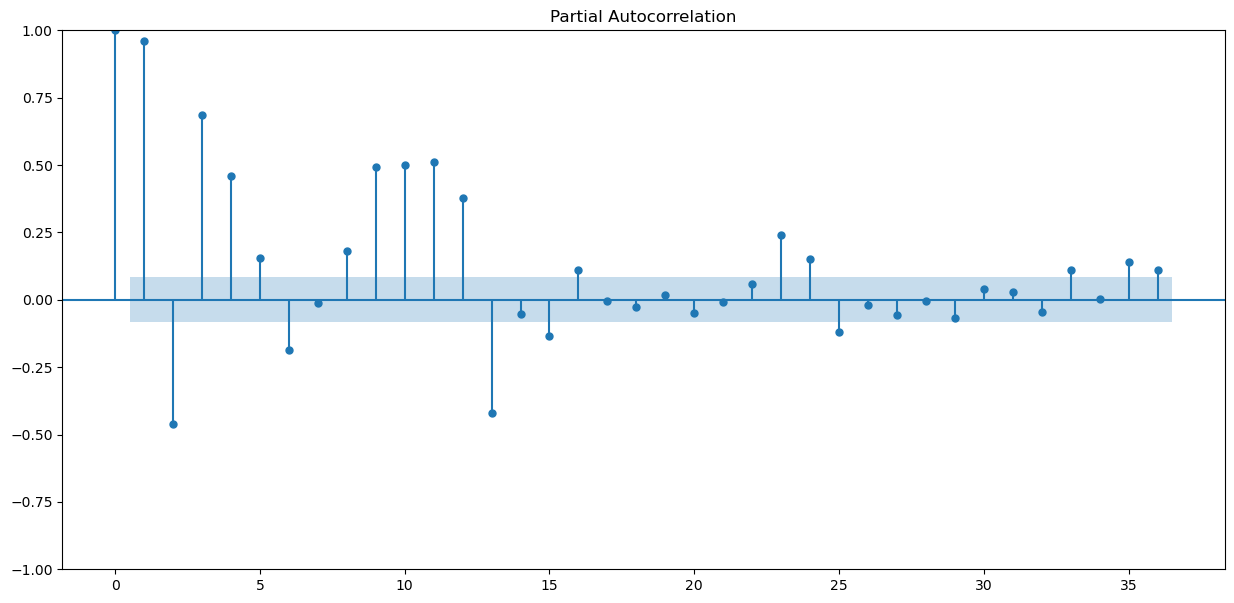

In [45]:
#Correlogram of pacf
smt.graphics.plot_pacf(cons, lags = 36, method='ols')
plt.show()

Based on PACF,the value of p =1, P=1

In [46]:
#To check stationarity of data
# Augmented Dickey-Fuller test:

adfuller(cons_spline)  

(-1.3145523996453001,
 0.622488554973442,
 15,
 548,
 {'1%': -3.442339408568417,
  '5%': -2.866828612425054,
  '10%': -2.5695866531248335},
 2342.4916984291576)

p-value:0.622488554973442; Since p-value is high, the series(cons_spline) is not stationary

In [47]:
#Transforming the Y variable to make the series stationary
cons_ln=np.log(cons_spline)

In [48]:
#ADF test on transformed Y variable
adfuller(cons_ln)

(-2.713322888560122,
 0.0717610654842426,
 15,
 548,
 {'1%': -3.442339408568417,
  '5%': -2.866828612425054,
  '10%': -2.5695866531248335},
 -2507.260203438013)

p-value:0.0717610654842426; Since p-value is high, the series(cons_ln) is not stationary

In [49]:
#Difference transformation of Y variable
cons_diff=cons_spline.diff().dropna()
cons_diff

DATE
1973-02-01     0.1606
1973-03-01    -1.0709
1973-04-01    -1.2209
1973-05-01    -0.3309
1973-06-01     2.9716
               ...   
2019-08-01    -0.3249
2019-09-01   -12.0575
2019-10-01     0.0000
2019-11-01     0.0000
2019-12-01     0.0000
Name: Consumption_Spline, Length: 563, dtype: float64

In [50]:
#ADF test on difference transformed series
adfuller(cons_diff)

(-7.591192886938373,
 2.5288093445162054e-11,
 14,
 548,
 {'1%': -3.442339408568417,
  '5%': -2.866828612425054,
  '10%': -2.5695866531248335},
 2338.4437996821607)

p-value:3.301343802151077e-12; Since p-value is low, the series(cons_diff) is stationary.

Since we did differencing only once, d=1.

Box-Jenkins process -to get approximate values of p,d,q.

Using above p,d,q values, we will come up with ranges to check which value is best value.

Model = SARIMA;
Model input time series = cons_diff;
(p,d,q) = (1,1,2);
(P,D,Q,T) = (1,0,1,12)

In [51]:
def auto_arima(timeseries, regressors=None, p=range(0, 2), d=range(0, 2), q=range(1, 3),
              P=range(0, 2), D=range(0, 1), Q=range(0, 2)):

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, d and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
    
    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_results = None
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                temp_model = sm.tsa.statespace.SARIMAX(endog=timeseries,
                                                 exog=regressors,
                                                 order = param,
                                                 seasonal_order = param_seasonal,
                                                 enforce_stationarity=False,
                                                 enforce_invertibility=False)
                temp_results = temp_model.fit()

                print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, temp_results.aic))
                
                if temp_results.aic < best_aic:
                    best_aic = temp_results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_results = temp_results
                
            except:
                #print("Unexpected error:", sys.exc_info()[0])
                continue
    print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_results.summary().tables[0])
    print(best_results.summary().tables[1])
    #return best_results

In [52]:
#Finding best values of (p,d,q),(P,D,Q) using Auto ARIMA
#best_results = auto_arima(cons_diff,  p=range(0, 3), d=range(2, 3), q=range(0, 3),
                        # P=range(0, 3), D=range(0, 2), Q=range(0, 3))    


In [53]:
#Splitting into train and test
train=cons_spline[:'2019-03-01']
test=cons_spline['2019-04-01':]

In [54]:
#Fitting the model with optimal values of (p,d,q)&(P,D,Q)
model = sm.tsa.statespace.SARIMAX(train, order = (2,2,2), seasonal_order= (1,1,2,12),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False).fit()

C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [55]:
#Model Summary
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                 Consumption_Spline   No. Observations:                  555
Model:             SARIMAX(2, 2, 2)x(1, 1, 2, 12)   Log Likelihood               -1045.733
Date:                            Mon, 28 Nov 2022   AIC                           2107.466
Time:                                    14:38:15   BIC                           2141.403
Sample:                                01-01-1973   HQIC                          2120.767
                                     - 03-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6456      0.044     14.733      0.000       0.560       0.731
ar.L2         -0.1187      0.046   

In [56]:
#Forecasting for test
f_cast = model.forecast(10)
f_cast

2019-04-01     87.653463
2019-05-01     93.349255
2019-06-01    107.505785
2019-07-01    118.640090
2019-08-01    117.096343
2019-09-01    104.973555
2019-10-01     93.608001
2019-11-01     91.311350
2019-12-01    100.937866
2020-01-01    107.839626
Freq: MS, Name: predicted_mean, dtype: float64

In [57]:
#Backward testing on values of one year
train_pred=model.fittedvalues['2017-04-01':]
train_pred

DATE
2017-04-01     85.323896
2017-05-01     93.374085
2017-06-01    106.075017
2017-07-01    119.046670
2017-08-01    119.042878
2017-09-01    109.624470
2017-10-01     94.581202
2017-11-01     91.332849
2017-12-01     98.999920
2018-01-01    108.399222
2018-02-01     97.296452
2018-03-01     88.612778
2018-04-01     88.662596
2018-05-01     92.235557
2018-06-01    107.896586
2018-07-01    117.927195
2018-08-01    118.929020
2018-09-01    103.753814
2018-10-01     91.252163
2018-11-01     92.075729
2018-12-01    101.054247
2019-01-01    105.855390
2019-02-01    101.880292
2019-03-01     93.169409
dtype: float64

In [58]:
#One year values of train data
train_check=train['2017-04-01':]
train_check

DATE
2017-04-01     87.4594
2017-05-01     92.2811
2017-06-01    109.6104
2017-07-01    121.7478
2017-08-01    123.2163
2017-09-01    108.4514
2017-10-01     93.4264
2017-11-01     89.9026
2017-12-01    101.8836
2018-01-01    102.9398
2018-02-01     92.0095
2018-03-01     93.3526
2018-04-01     86.8386
2018-05-01     93.2361
2018-06-01    107.1009
2018-07-01    119.2874
2018-08-01    115.7108
2018-09-01    103.4070
2018-10-01     94.6492
2018-11-01     91.9079
2018-12-01    101.9883
2019-01-01    111.8520
2019-02-01     97.3261
2019-03-01     93.8406
Name: Consumption_Spline, dtype: float64

In [59]:
#MAPE on train data
print('train_error_last1year:', np.mean(np.abs(train_check-train_pred)/train_check))

train_error_last1year: 0.02455826664965056


In [60]:
#MAPE on test data
print('test_error_last1year:', np.mean(np.abs(test-f_cast)/test))

test_error_last1year: 0.06616953884219938


In [61]:
model_sarima = sm.tsa.statespace.SARIMAX(cons_spline, order = (2,2,2), seasonal_order= (1,1,2,12),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False).fit()

C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\itsfe\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [62]:
#Summary of the time series model on whole data
print(model_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                 Consumption_Spline   No. Observations:                  564
Model:             SARIMAX(2, 2, 2)x(1, 1, 2, 12)   Log Likelihood               -1093.355
Date:                            Mon, 28 Nov 2022   AIC                           2202.711
Time:                                    14:38:25   BIC                           2236.788
Sample:                                01-01-1973   HQIC                          2216.057
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6557      0.049     13.280      0.000       0.559       0.752
ar.L2         -0.1531      0.045   

In [63]:
#Predicting electricity demand for next two years
fcast_sarima=model_full.forecast(24)
fcast_sarima

NameError: name 'model_full' is not defined

In [ ]:
#Plot showing observed and forecasted values using SARIMA
plt.plot(cons_spline, '--', label='Observed')
plt.plot(fcast_sarima, '-', label='Forecasted')

In [ ]:
#Diagnostics of the residuals within data
model_sarima.plot_diagnostics(lags=24, figsize=(16,12))
plt.show()

Errors are following normal distribution.

From ACF of Errors,it is clear that error series is White Noise/Random Walk, ie, there is no auto-correlation among errors.

## Forecasting using Prophet Package

In [ ]:
#Data Preprocessing for using Prophet
cons_final.reset_index(inplace=True)
cons_final.head()

In [ ]:
#Extracting the date and value columns for executing Prophet
cons_prophet=cons_final[['DATE','Consumption_Spline']]
cons_prophet.head()

In [ ]:
#Renaming the columns
cons_prophet.rename(columns={'DATE':'ds','Consumption_Spline':'y'},inplace=True)

In [ ]:
#Fitting the model on data
model=Prophet()
model.fit(df=cons_prophet)

In [ ]:
#Future dataframe
future=model.make_future_dataframe(periods=24,freq='MS')
future

In [ ]:
cons_final.tail()

In [ ]:
future.tail()

In [ ]:
#Predicting values using Prophet
pred_prophet=model.predict(future)
pred_prophet.head()

In [ ]:
#Predicted values with upper and lower limits
pred_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

In [ ]:
#Forecasted values for next two years
pred_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(24)

In [ ]:
#Plotting of predicted and observed values
model.plot(pred_prophet)
plt.show()

In [ ]:
#Checking the Trend and Seasonality Components
model.plot_components(pred_prophet)
plt.show()

From the above,ETS and SARIMA models can be considered as good models in predicting electricity demand.Based on metrics, the best model is ETS.